# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima import auto_arima

In [2]:
import warnings
warnings.filterwarnings("ignore")

# 1. Correlations in MA models

## MA model

In [3]:
def MovingAverage(c,n,burnin,params,epsilon,init):
    y = init
    for i in range(len(init)-1,n):
        y.append(c + epsilon[i] + sum(params[j]*epsilon[i-j-1] for j in range (len(params))))
    return y[burnin:]

In [4]:
n = 5000
burnin = 200
c = 20

In [5]:
theta = [0.8]
noise = np.random.normal(0,1,n+burnin)
MR = MovingAverage(c,n+burnin,burnin,theta,noise,[c])

Text(0.5, 1.0, 'PACF')

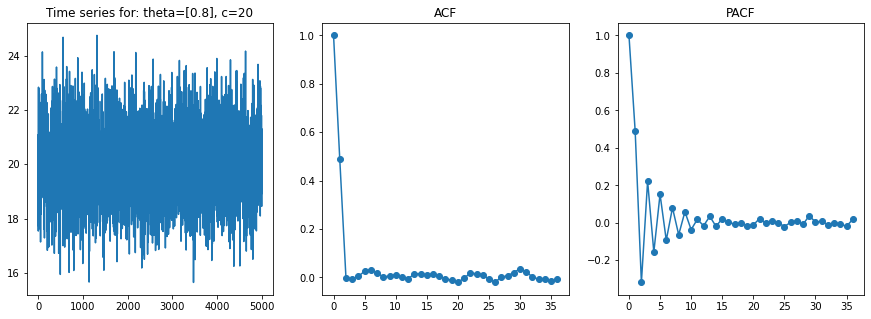

In [6]:
fir,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(MR)
ax[0].set_title(f'Time series for: theta={theta}, c={c}')
ax[1].plot(acf(MR),marker='o')
ax[1].set_title('ACF')
ax[2].plot(pacf(MR),marker='o')
ax[2].set_title('PACF')

In [7]:
c = 20
theta = [-1,0.8]
noise = np.random.normal(0,1,n+burnin)
MR = MovingAverage(c,n+burnin,burnin,theta,noise,[c])

Text(0.5, 1.0, 'PACF')

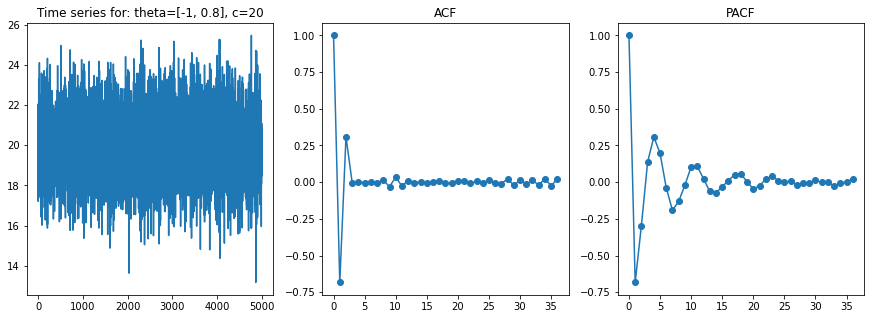

In [8]:
fir,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(MR)
ax[0].set_title(f'Time series for: theta={theta}, c={c}')
ax[1].plot(acf(MR),marker='o')
ax[1].set_title('ACF')
ax[2].plot(pacf(MR),marker='o')
ax[2].set_title('PACF')

# 2. ARIMA forecasting

## Reading data

In [9]:
df=pd.read_csv('INVCMRMT.csv',parse_dates=True, index_col='DATE')
df

,INVCMRMT
DATE,
1997-01-01,1301161.0
1997-02-01,1307080.0
1997-03-01,1303978.0
1997-04-01,1319740.0
1997-05-01,1327294.0
...,...
2018-08-01,2156969.0
2018-09-01,2163820.0
2018-10-01,2172890.0


<AxesSubplot:xlabel='DATE'>

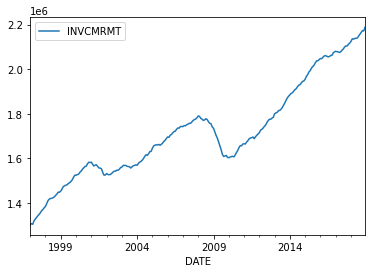

In [10]:
df.plot()

## Finding the best ARIMA(p,1,q) model.

In [11]:
testlen = 12
trainlen = len(df) - testlen
train = df.iloc[:trainlen]
test = df.iloc[trainlen:]
start = len(train)
stop = len(df)-1

In [12]:
test

,INVCMRMT
DATE,
2018-01-01,2124655.0
2018-02-01,2135865.0
2018-03-01,2134146.0
2018-04-01,2138236.0
2018-05-01,2137865.0
2018-06-01,2139842.0
2018-07-01,2148096.0
2018-08-01,2156969.0
2018-09-01,2163820.0


### Using auto_arima()

In [13]:
autoArima = auto_arima(train,seasonal=False,trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5133.472, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5101.966, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5167.428, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5104.660, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5160.400, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5140.514, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.110 seconds


In [14]:
bestAutoArima = ARIMA(train, order=(0,1,0)).fit()

In [15]:
bestAutoArima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               INVCMRMT   No. Observations:                  252
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2579.200
Date:                Wed, 18 May 2022   AIC                           5160.400
Time:                        15:31:40   BIC                           5163.925
Sample:                    01-01-1997   HQIC                          5161.818
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.911e+07    4.8e+06     10.231      0.000    3.97e+07    5.85e+07
===================================================================================
Ljung-Box (L1) (Q):                  91.78   Jarque-Bera (JB):               114.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -1.24
Prob(H) (two-sided):                  0.62   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
predAutoArima = bestAutoArima.predict(start=start,end=stop,dynamic=False).rename(f'Arima(0,1,0)')

<AxesSubplot:xlabel='DATE'>

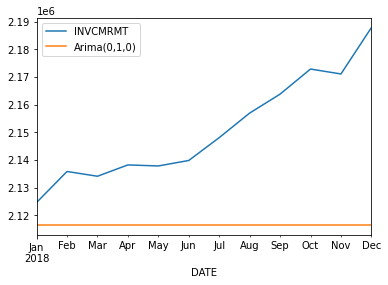

In [17]:
ax = test.plot()
predAutoArima.plot(ax=ax, legend=True)

### It looks not good... but let's check mean_absolute_percentage_error

In [18]:
errorAutoArima = mean_absolute_percentage_error(test, predAutoArima)
errorAutoArima

0.015982508105570645

### From scratch

In [19]:
results = {}
for p in range(0,10):
    for q in range(0,10):
        arima = ARIMA(train, order=(p,1,q)).fit()
        pred = arima.forecast(12)
        results[(p,q)] = mean_absolute_percentage_error(test,pred)

In [20]:
bestModel = min(results, key=results.get)

In [21]:
##best p and q:
p = bestModel[0]
q = bestModel[1]
print(f'Best model: p = {p}, q = {q}')

Best model: p = 1, q = 1


In [22]:
bestArima = ARIMA(train, order=(p,1,q)).fit()

In [23]:
bestArima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               INVCMRMT   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2549.240
Date:                Wed, 18 May 2022   AIC                           5104.481
Time:                        15:33:12   BIC                           5115.057
Sample:                    01-01-1997   HQIC                          5108.737
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.002    537.101      0.000       0.996       1.004
ma.L1         -0.9995      0.010   -104.713      0.000      -1.018      -0.981
sigma2      3.874e+07   4.72e-12   8.21e+18      0.000    3.87e+07    3.87e+07
===================================================================================
Ljung-Box (L1) (Q):                  91.78   Jarque-Bera (JB):               107.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -1.22
Prob(H) (two-sided):                  0.14   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.81e+34. Standard errors may be unstable.
"""

In [24]:
predArima = bestArima.predict(start=start,end=stop,dynamic=False).rename(f'Arima({p},1,{q})')

<AxesSubplot:xlabel='DATE'>

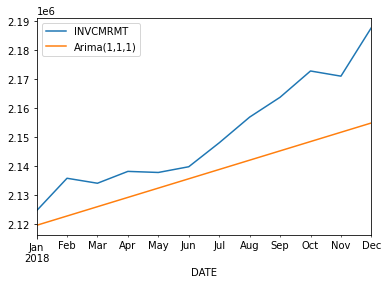

In [25]:
ax = test.plot()
predArima.plot(ax=ax, legend=True)

In [26]:
errorArima = mean_absolute_percentage_error(test, predArima)
errorArima

0.006317789381328632

### This method give better results

## Differencing data

<AxesSubplot:xlabel='DATE'>

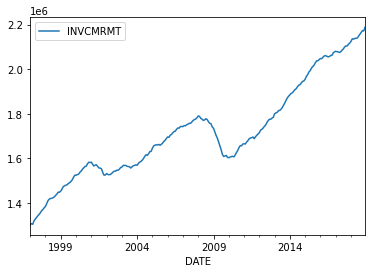

In [27]:
dfdiff = df.copy(deep=True)
dfdiff.plot()

<AxesSubplot:xlabel='DATE'>

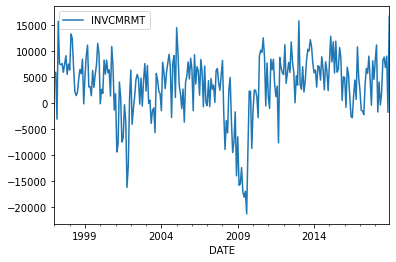

In [28]:
dfdiff['INVCMRMT'] = dfdiff['INVCMRMT'].diff()
dfdiff.plot()

In [29]:
dfdiff = dfdiff.apply (pd.to_numeric, errors='coerce')
dfdiff = dfdiff.dropna()

## Verifying stationarity

In [30]:
adfuller(dfdiff)

(-3.396259252529265,
 0.011087056354521115,
 4,
 258,
 {'1%': -3.455952927706342,
  '5%': -2.8728086526320302,
  '10%': -2.572774990685656},
 4880.823933425189)

In [31]:
kpss(dfdiff)

(0.18860917375262498,
 0.1,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### It's not stationary